In [1]:
import pandas as pd
import numpy as np
import pycmap
import os.path
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
import math
import requests
from bs4 import BeautifulSoup
import re

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

In [2]:
# calls api from cmap and uses my token to do that
api = pycmap.API(token = "d24b5240-ea3a-45bd-8174-fdb7830d805f")

In [3]:
## this is a way to call the seaflow metadata to python from google drive
SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']

# The ID and range of a sample spreadsheet.
SAMPLE_SPREADSHEET_ID = '1Tsi7OWIZWfCQJqLDpId2aG_i-8Cp-p63PYjjvDkOtH4'
SAMPLE_RANGE_NAME = 'metadata'
creds = None
# The file token.json stores the user's access and refresh tokens, and is
# created automatically when the authorization flow completes for the first
# time.
if os.path.exists('token.json'):
    creds = Credentials.from_authorized_user_file('token.json', SCOPES)
# If there are no (valid) credentials available, let the user log in.
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            'credentials.json', SCOPES)
        creds = flow.run_local_server(port=0)
    # Save the credentials for the next run
    with open('token.json', 'w') as token:
        token.write(creds.to_json())
try:
    service = build('sheets', 'v4', credentials=creds)

    # Call the Sheets API
    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID,
                                range=SAMPLE_RANGE_NAME).execute()
    values = result.get('values', [])

    if not values:
        print('No data found.')

except HttpError as err:
    print(err)

In [4]:
seaflow_meta=pd.DataFrame(values)
seaflow_meta.columns=seaflow_meta.iloc[0]
seaflow_meta1 = seaflow_meta.iloc[1:]
# this seaflow_meta 

In [5]:
def read_sfl(x):
    df = pd.read_csv(x, sep = '\t')
    cruise_split = x.rsplit('/',1)[-1]
    #output will be a string
    cruise_short = cruise_split.replace('.sfl', '')
    cruise_list = cruise_short.split('_')
    if len(cruise_list) > 2:
        cruise = "_".join([cruise_list[0], cruise_list[1]])
    elif len(cruise_list) == 2:
        cruise = cruise_list[0]
    ship = seaflow_meta.loc[seaflow_meta['cruise'] ==  cruise, 'Ship'].values[0]
    print(cruise)
    df['cruise'] = cruise
    df['ship'] = ship
    return df

#### .values converts pd.series to list but we had to get string from the list which is the first one 

In [14]:
sfl = read_sfl("https://raw.githubusercontent.com/seaflow-uw/seaflow-sfl/master/curated/DeepDOM_989.sfl")

DeepDOM


In [15]:
sfl

,FILE,DATE,FILE DURATION,LAT,LON,CONDUCTIVITY,SALINITY,OCEAN TEMP,PAR,BULK RED,STREAM PRESSURE,EVENT RATE,cruise,ship
0,2013_084/1.evt,2013-03-25T22:26:18+00:00,180,-35.2701,-53.9193,4.2799,30.3408,20.6960,2.88,315.3193,11.46,6554,DeepDOM,R/V Knorr
1,2013_084/2.evt,2013-03-25T22:29:19+00:00,180,-35.2751,-53.9089,4.2825,30.3495,20.7131,2.13,289.7130,12.00,10374,DeepDOM,R/V Knorr
2,2013_084/3.evt,2013-03-25T22:32:19+00:00,180,-35.2802,-53.8979,4.2727,30.2842,20.6959,2.13,203.3337,12.00,10099,DeepDOM,R/V Knorr
3,2013_084/4.evt,2013-03-25T22:35:19+00:00,180,-35.2857,-53.8871,4.2736,30.2921,20.6948,1.88,178.3893,12.00,9959,DeepDOM,R/V Knorr
4,2013_084/5.evt,2013-03-25T22:38:19+00:00,180,-35.2913,-53.8761,4.2725,30.3122,20.6545,2.63,165.5252,12.00,9796,DeepDOM,R/V Knorr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18438,2013_124/405.evt,2013-05-04T23:46:40+00:00,180,9.6966,-55.2838,5.4849,33.5621,28.6630,NaN,67.7477,12.00,31084,DeepDOM,R/V Knorr
18439,2013_124/406.evt,2013-05-04T23:49:41+00:00,180,9.6957,-55.2837,5.4811,33.5396,28.6575,NaN,240.7669,12.00,31028,DeepDOM,R/V Knorr
18440,2013_124/407.evt,2013-05-04T23:53:40+00:00,180,9.6953,-55.2837,5.4827,33.5672,28.6339,NaN,69.2142,18.41,28395,DeepDOM,R/V Knorr
18441,2013_124/408.evt,2013-05-04T23:56:40+00:00,180,9.6954,-55.2837,5.4910,33.6119,28.6514,NaN,71.4513,12.00,31348,DeepDOM,R/V Knorr


In [19]:
# this calls the rest of the sfl files from github sfl repo and uses beautiful soup to parse the text
github_url = 'https://github.com/seaflow-uw/seaflow-sfl/tree/master/curated'
results = requests.get(github_url)
soup = BeautifulSoup(results.text).get_text()

regex = '\.sfl'
match = pd.unique(re.findall('name.*?\.sfl', soup[560:]) )
# clean it up
filenames=[]
for i in match:
    filenames.append(i.split('"')[-1:][0])

In [20]:
filenames

['DeepDOM_989.sfl',
 'GP15_1_751.sfl',
 'GP15_2_751.sfl',
 'HOT-294_751.sfl',
 'HOT297_751.sfl',
 'HOT299_751.sfl',
 'HOT300_751.sfl',
 'HOT301_751.sfl',
 'HOT302_751.sfl',
 'HOT303_751.sfl',
 'HOT304_751.sfl',
 'HOT307_740.sfl',
 'HOT308_740.sfl',
 'HOT309_740.sfl',
 'HOT310_740.sfl',
 'HOT312_740.sfl',
 'HOT313_740.sfl',
 'HOT314_740.sfl',
 'HOT315_740.sfl',
 'HOT317_740.sfl',
 'HOT318_740.sfl',
 'HOT319_740.sfl',
 'HOT321_740.sfl',
 'HOT322_740.sfl',
 'HOT323_740.sfl',
 'HOT324_740.sfl',
 'HOT325_740.sfl',
 'HOT326_740.sfl',
 'HOT328_740.sfl',
 'HOT329_740.sfl',
 'HOT330_740.sfl',
 'HOT331_740.sfl',
 'HOT332_740.sfl',
 'HOT335_740.sfl',
 'HOT336_740.sfl',
 'HOT337_740.sfl',
 'HOT338_740.sfl',
 'KM1712_751.sfl',
 'KM1713_751.sfl',
 'KM1906_740.sfl',
 'KM1906_towfish_751.sfl',
 'KM1919_751.sfl',
 'KM1920_751.sfl',
 'KM1923_740_740.sfl',
 'KM1923_751_751.sfl',
 'KM2206_130_130.sfl',
 'KM2206_740_740.sfl',
 'KOK1805_751.sfl',
 'KOK1806_751.sfl',
 'KiloMoana_1_740.sfl',
 'MBARI_1_989.sfl

In [29]:
# def list_cruises():
#     new_sfl = []
#     all_cruises = []
#     for i in filenames:
#         new_sfl.append(github_url + '/' + i)
#     for i in new_sfl:
#         read_sfl(i)
#     return list_cruises

In [23]:
# creates empty list so i can put entire github url in it so i can run read_sfl in it
all_cruises = []
raw_github = 'https://raw.githubusercontent.com/seaflow-uw/seaflow-sfl/master/curated'
for i in filenames:
    new_sfl = raw_github + '/' + i
    all_cruises.append(read_sfl(new_sfl))

DeepDOM
GP15_1
GP15_2
HOT-294
HOT297
HOT299
HOT300
HOT301
HOT302
HOT303
HOT304
HOT307
HOT308
HOT309
HOT310
HOT312
HOT313
HOT314
HOT315
HOT317
HOT318
HOT319
HOT321
HOT322
HOT323
HOT324
HOT325
HOT326
HOT328
HOT329
HOT330
HOT331
HOT332
HOT335
HOT336
HOT337
HOT338
KM1712
KM1713
KM1906
KM1906_towfish
KM1919
KM1920
KM1923_740
KM1923_751
KM2206_130
KM2206_740
KOK1805
KOK1806
KiloMoana_1
MBARI_1
MBARI_2
MBARI_3
MESO_SCOPE
MGL1704
SCOPE-PARAGONII
SCOPE-PARAGON
SCOPE_10
SCOPE_11
SCOPE_12
SCOPE_13
SCOPE_14
SCOPE_15
SCOPE_16
SCOPE_17
SCOPE_18
SCOPE_19
SCOPE_1
SCOPE_2
SCOPE_3
SCOPE_4
SCOPE_5
SCOPE_6
SCOPE_9
SCOPE_Falkor1
SCOPE_Falkor2
SR1917
TN396_130
TN396_740
TN397_130
TN397_740
TN398
TN412_130
TN413
TN414
Thompson_0
Thompson_10
Thompson_11
Thompson_12
Thompson_1
Thompson_2
Thompson_3
Thompson_4
Thompson_5
Thompson_6
Thompson_7
Thompson_8
Thompson_9
Tokyo_1
Tokyo_2
Tokyo_3
Tokyo_4


In [27]:
all_sfl = pd.concat(all_cruises)
all_sfl

,FILE,DATE,FILE DURATION,LAT,LON,CONDUCTIVITY,SALINITY,OCEAN TEMP,PAR,BULK RED,STREAM PRESSURE,EVENT RATE,cruise,ship
0,2013_084/1.evt,2013-03-25T22:26:18+00:00,180.000,-35.2701,-53.9193,4.27990,30.3408,20.6960,2.88,315.3193,11.46,6554.0,DeepDOM,R/V Knorr
1,2013_084/2.evt,2013-03-25T22:29:19+00:00,180.000,-35.2751,-53.9089,4.28250,30.3495,20.7131,2.13,289.7130,12.00,10374.0,DeepDOM,R/V Knorr
2,2013_084/3.evt,2013-03-25T22:32:19+00:00,180.000,-35.2802,-53.8979,4.27270,30.2842,20.6959,2.13,203.3337,12.00,10099.0,DeepDOM,R/V Knorr
3,2013_084/4.evt,2013-03-25T22:35:19+00:00,180.000,-35.2857,-53.8871,4.27360,30.2921,20.6948,1.88,178.3893,12.00,9959.0,DeepDOM,R/V Knorr
4,2013_084/5.evt,2013-03-25T22:38:19+00:00,180.000,-35.2913,-53.8761,4.27250,30.3122,20.6545,2.63,165.5252,12.00,9796.0,DeepDOM,R/V Knorr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3160,2012_037/418.evt,2012-02-06T20:52:52+00:00,179.987,33.6448,-118.4801,4.09840,33.3094,14.7736,NaN,77.4531,4.06,0.0,Tokyo_4,M/V Tokyo
3161,2012_037/419.evt,2012-02-06T20:55:52+00:00,180.405,33.6407,-118.4721,4.09931,33.3057,14.7814,NaN,71.7936,4.03,0.0,Tokyo_4,M/V Tokyo
3162,2012_037/420.evt,2012-02-06T20:58:53+00:00,180.182,33.6367,-118.4639,4.10011,33.2993,14.7970,NaN,60.4821,4.02,0.0,Tokyo_4,M/V Tokyo
3163,2012_037/421.evt,2012-02-06T21:01:53+00:00,180.131,33.6327,-118.4558,4.10251,33.3005,14.8224,NaN,67.4903,4.03,0.0,Tokyo_4,M/V Tokyo


In [47]:
pd.to_datetime(all_sfl['DATE'])
# this converts all_sfl date column from object type to datetime in UTC

datetime_index = pd.DatetimeIndex(all_sfl.DATE.values).tz_convert('UTC')
df2 = all_sfl.set_index(datetime_index).reset_index()
df2.rename(columns={"index": "Date"}, inplace = True)
df2.drop(columns = ['DATE'], inplace = True)

# convert datetime64 to datetimeindex for groupby function to work
## i changed df because i was scared to mess up all_sfl df i was working with so I may have to change code to alter all_sfl df

In [49]:
sfl_hourly = df2.groupby([pd.Grouper(key = 'Date', freq = 'H'), 'cruise']).agg({'PAR': 'mean'}, numeric_only = True).reset_index()
# goal here is to group cruise and date column and . agg mean par to get hourly par data

TypeError: Could not convert 1096.70001075.00001055.20001031.10001008.3000979.8100956.6500855.7900850.4000822.6700801.6600777.1500 to numeric

In [ ]:
def check_int(value):
    try:
        int(value)
        return np.NaN
    except ValueError:
        return value

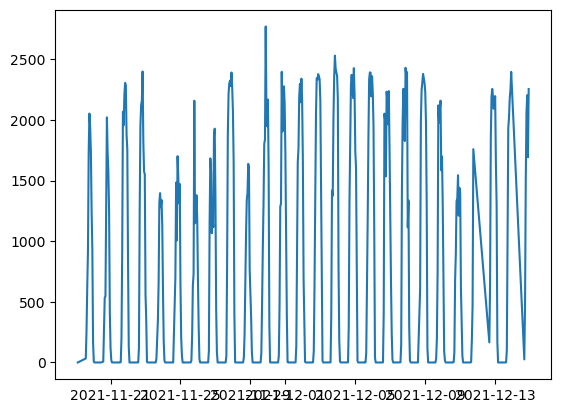

In [25]:
x = sfl_hourly.Date
y = sfl_hourly.PAR
plt.plot(x, y)

In [23]:
df2.PAR = 10**-6 * df2.PAR * 24 * 60 * 60
# time to convert PAR units from microeinstein to einstein to match satellite date

In [24]:
lat_value = df2[df2.LAT.notnull()]
lon_value = df2[df2.LON.notnull()]
# here i've set indexed out the NaN values in lat and lon column before putting it into groupby function

sfl_daily = df2.groupby([pd.Grouper(key = 'Date', freq = 'D'), 'cruise', 'ship']).agg({
    'PAR': 'mean',
    'LAT': ['min', 'max'],
    'LON': ['min', 'max']}).reset_index()
# using group by to get the daily mean of par based on cruise, ship, etc. and removes any NaN values found. gets minimum and max of lat and lon based on daily scale

sfl_daily['sat_PAR'] = ''
# cretes empty column for sat_par that will be input by cmap data later

sfl_daily.columns = [' '.join(col).strip() for col in sfl_daily.columns.values]
# this flattens the multindex and joins the diff levels to create a min and max lat and lon instead of duplicate lat and lon columns

In [26]:
# cleaning up min_lat values
clean_sfl = sfl_daily.replace([np.inf, -np.inf], np.nan).dropna(subset=["LAT min", 
                                                            "LAT max",
                                                            'LON min',
                                                            'LON max'], how="any")

In [27]:
# colocalizing cmap data, sepcifically modis par data

for index,row in clean_sfl.iterrows():
    print(index, row)
    df = api.space_time(table='tblModis_PAR',
                   variable='PAR',
                   dt1= str(row['Date']),
                   dt2= str(row['Date']),
                   lat1= row['LAT min'],
                   lat2= row['LAT max'],
                   lon1= row['LON min'],
                   lon2= row['LON max'],
                   depth1=0,
                   depth2=10)
    try:
        clean_sfl.loc[index, 'sat_PAR'] = np.mean(df.PAR)
    except:
        clean_sfl.loc[index, 'sat_PAR'] = np.nan

0 Date        2021-11-19 00:00:00+00:00
cruise                      TN397_130
ship            R/V Thomas G Thompson
PAR mean                    97.160599
LAT min                      30.28238
LAT max                       32.7066
LON min                    -121.27732
LON max                     -117.2363
sat_PAR                              
Name: 0, dtype: object
1 Date        2021-11-20 00:00:00+00:00
cruise                      TN397_130
ship            R/V Thomas G Thompson
PAR mean                    32.635551
LAT min                     28.435675
LAT max                       30.2781
LON min                     -124.4034
LON max                    -121.28435
sat_PAR                              
Name: 1, dtype: object
2 Date        2021-11-21 00:00:00+00:00
cruise                      TN397_130
ship            R/V Thomas G Thompson
PAR mean                    56.548363
LAT min                     26.238867
LAT max                     28.436408
LON min                     -128.042

23 Date        2021-12-12 00:00:00+00:00
cruise                      TN397_130
ship            R/V Thomas G Thompson
PAR mean                   152.045408
LAT min                     11.919346
LAT max                      12.48051
LON min                    -151.12164
LON max                   -150.685925
sat_PAR                              
Name: 23, dtype: object
24 Date        2021-12-13 00:00:00+00:00
cruise                      TN397_130
ship            R/V Thomas G Thompson
PAR mean                    62.330895
LAT min                     12.488915
LAT max                     15.170767
LON min                   -153.170478
LON max                   -151.127946
sat_PAR                              
Name: 24, dtype: object
25 Date        2021-12-14 00:00:00+00:00
cruise                      TN397_130
ship            R/V Thomas G Thompson
PAR mean                   128.512189
LAT min                     18.180617
LAT max                       19.2624
LON min                   -156.

In [28]:
# calculates the correction factor and makes column in clean_sfl

correction = (clean_sfl['sat_PAR'] / clean_sfl['PAR mean']).median()
clean_sfl['correction'] = correction

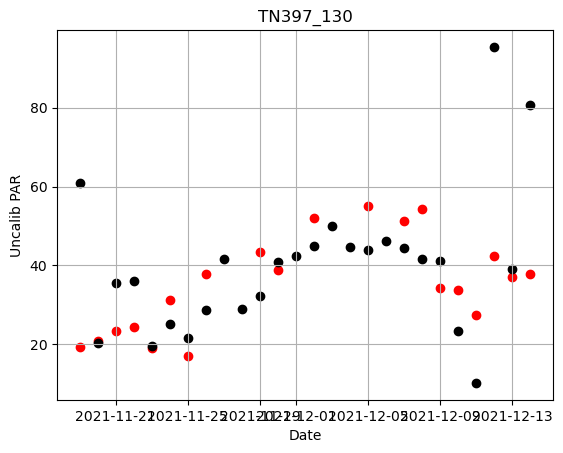

In [31]:
# figure plotting stuff out later

x = clean_sfl['Date']
y1 = clean_sfl['sat_PAR']
y2 = clean_sfl['PAR mean'] * correction


plt.scatter(x, y1, color='red', label='sat_PAR')
plt.scatter(x, y2, color='black', label='PAR')


plt.xlabel("Date")
plt.ylabel("Uncalib PAR")
plt.title("TN397_130") ### change this so that each plot made is specific to matching cruise .. idk how yet
plt.grid()

In [32]:
calib = clean_sfl.groupby(['cruise', 'ship']).agg({
    'Date' : 'mean',
    'correction' : 'mean'
}).round(3)

In [33]:
calib

,,Date,correction
cruise,ship,,
TN397_130,R/V Thomas G Thompson,2021-12-01 12:00:00+00:00,0.627
